In [1]:
from datetime import datetime
import dask.array as da
import os
import time
import h5py
import numpy as np
import xarray as xr
import downscale as down

import geopandas as gpd

import cartopy
import cartopy.feature as cf
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cartopy.io.shapereader as shpreader

from matplotlib import patches
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.gridspec as gridspec

from shapely.geometry import Polygon, mapping

import warnings
warnings.filterwarnings('ignore')

In [2]:
Veneto = gpd.read_file(os.path.join('/','media','arturo','Arturo','Data','shapes','Europa','Italy','Veneto.geojson'))

In [3]:
data_dir = os.path.join('/','media','arturo','Arturo','Data','Italy','Satellite','IMERG','IMERG_Italy_1dy_2000_06_01_2024_02_29.nc')
DATA = xr.open_dataset(data_dir)

lon2d, lat2d = np.meshgrid(DATA['lon'], DATA['lat'])
PRE = DATA['PRE'].data

DATA

<xarray.Dataset> Size: 1GB
Dimensions:  (time: 8674, lat: 121, lon: 131)
Coordinates:
  * time     (time) datetime64[ns] 69kB 2000-06-01 2000-06-02 ... 2024-02-29
  * lat      (lat) float64 968B 35.95 36.05 36.15 36.25 ... 47.75 47.85 47.95
  * lon      (lon) float32 524B 5.95 6.05 6.15 6.25 ... 18.65 18.75 18.85 18.95
Data variables:
    PRE      (time, lat, lon) float64 1GB 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.015
Attributes:
    description:  IMERG daily data for Italy region

In [5]:
INFO = mapping(Veneto)

In [6]:
lat_veneto = []
lon_veneto = []
for nn in range(len(INFO['features'][0]['geometry']['coordinates'][0][0])):
    lon_veneto.append(INFO['features'][0]['geometry']['coordinates'][0][0][nn][0])
    lat_veneto.append(INFO['features'][0]['geometry']['coordinates'][0][0][nn][1])

lo_max, lo_min = np.max(lon_veneto), np.min(lon_veneto)
la_max, la_min = np.max(lat_veneto), np.min(lat_veneto)

In [7]:
lo_max, lo_min, la_max, la_min

(13.102129, 10.623646, 46.680462, 44.790684)

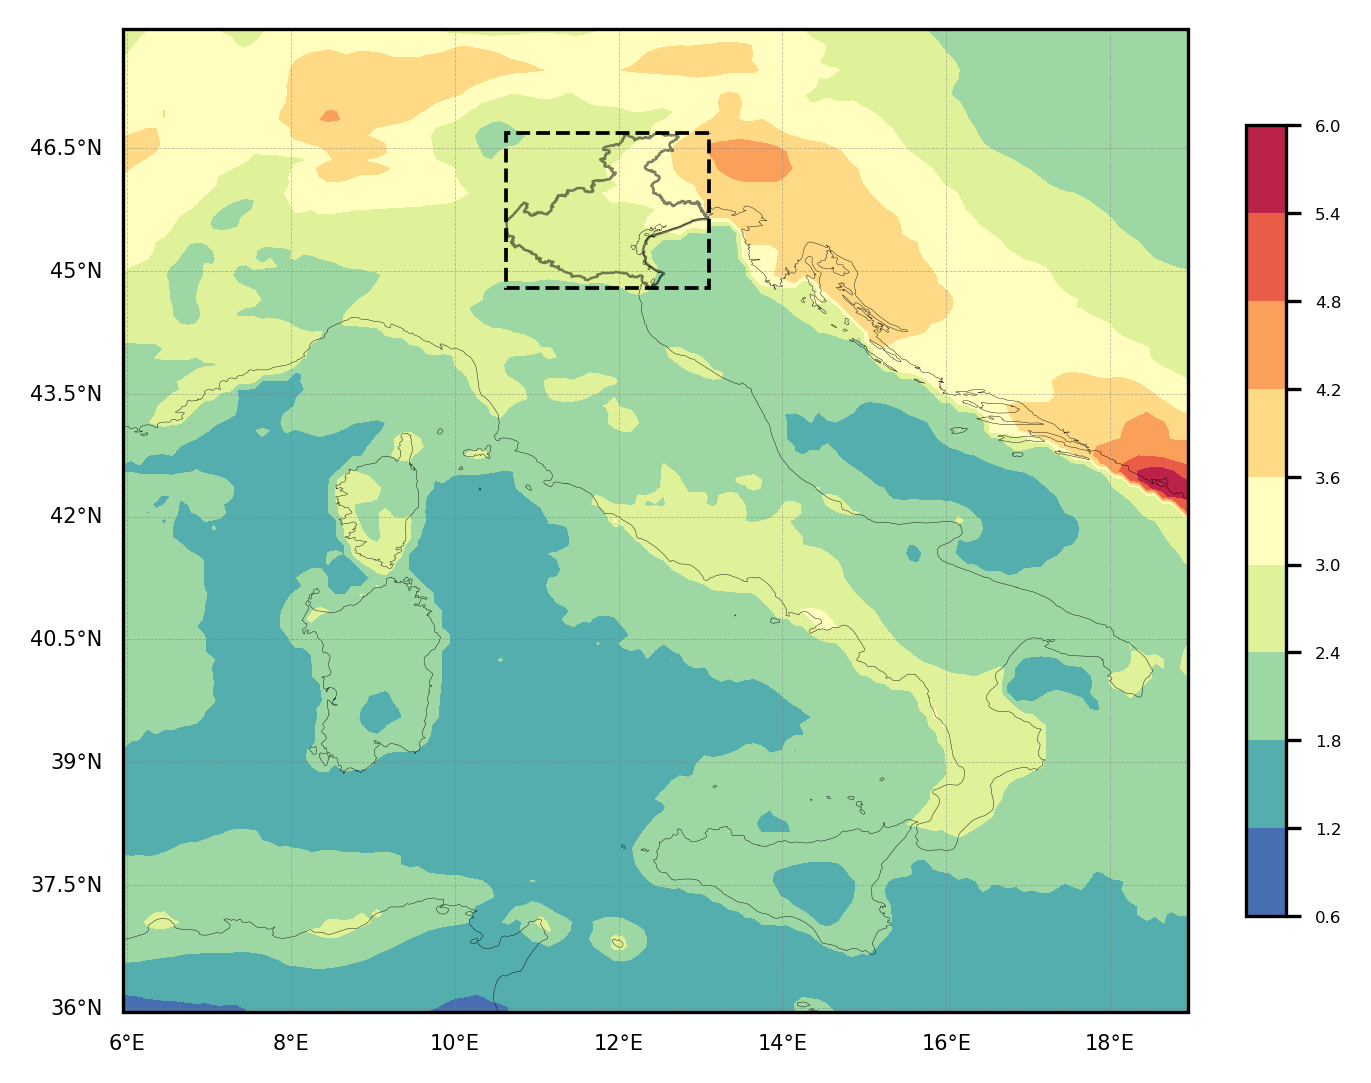

In [8]:
cmap = plt.cm.Spectral_r
proj = ccrs.PlateCarree()

fig = plt.figure(figsize=(5,5),dpi=300)
gs = gridspec.GridSpec(1,1)

# ============================================================================================================================
ax1 = plt.subplot(gs[0, 0], projection = proj)
# ax1.set_extent([-94, -90.5, 31, 34], crs=proj)
ax1.add_feature(cf.COASTLINE,linewidth=0.1, linestyle='-',edgecolor='k')
a1 = ax1.contourf(lon2d, lat2d, np.nanmean(PRE,axis=0), cmap=cmap)
ax1.add_patch(patches.Rectangle((lo_max,la_max),lo_min-lo_max,la_min-la_max,linestyle='--',linewidth=0.9,edgecolor='k',facecolor='None',zorder=10))
ax1.add_geometries(Veneto.geometry, ccrs.PlateCarree(), edgecolor='k', facecolor='None', linewidth=0.6, alpha=0.5)

gl = ax1.gridlines(crs=proj,draw_labels=True,linewidth=0.2,color='gray',alpha=0.5,linestyle='--')
gl.top_labels = False
gl.bottom_labels = True
gl.right_labels = False
gl.xlabel_style = {'size': 5, 'color': 'k'}
gl.ylabel_style = {'size': 5, 'color': 'k'}

cbar = plt.colorbar(a1, fraction=0.034)
cbar.ax.tick_params(labelsize=4)

In [10]:
cropped_ds = DATA.sel(lat=slice(la_min, la_max), lon=slice(lo_min, lo_max))
# cropped_ds = DATA.sel(lat=slice(45.5, 46.5), lon=slice(12, 13))

lon2d_ref, lat2d_ref = np.meshgrid(cropped_ds['lon'], cropped_ds['lat'])
cropped_ds

<xarray.Dataset> Size: 7MB
Dimensions:  (time: 8674, lat: 10, lon: 10)
Coordinates:
  * time     (time) datetime64[ns] 69kB 2000-06-01 2000-06-02 ... 2024-02-29
  * lat      (lat) float64 80B 45.55 45.65 45.75 45.85 ... 46.25 46.35 46.45
  * lon      (lon) float32 40B 12.05 12.15 12.25 12.35 ... 12.75 12.85 12.95
Data variables:
    PRE      (time, lat, lon) float64 7MB 0.0 0.0 0.0 0.0 ... 1.395 0.41 0.52
Attributes:
    description:  IMERG daily data for Italy region

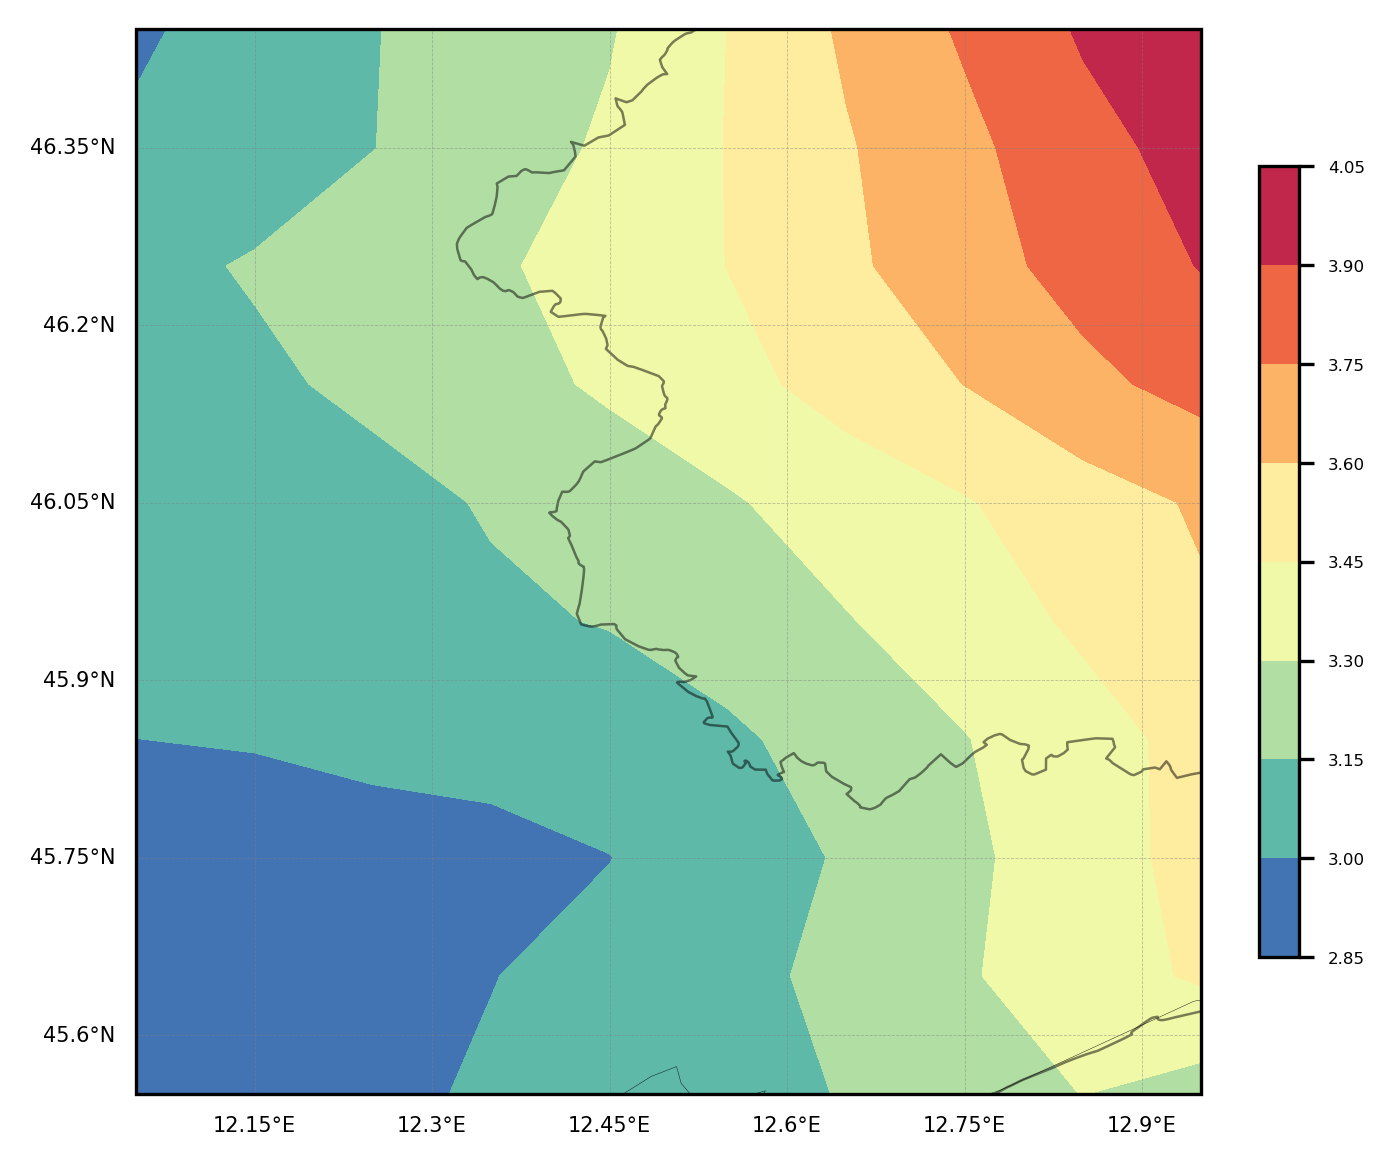

In [11]:
cmap = plt.cm.Spectral_r
proj = ccrs.PlateCarree()

fig = plt.figure(figsize=(5,5),dpi=300)
gs = gridspec.GridSpec(1,1)

# ============================================================================================================================
ax1 = plt.subplot(gs[0, 0], projection = proj)
ax1.add_feature(cf.COASTLINE,linewidth=0.1, linestyle='-',edgecolor='k')
a1 = ax1.contourf(lon2d_ref, lat2d_ref, np.nanmean(cropped_ds['PRE'],axis=0), cmap=cmap)
ax1.add_patch(patches.Rectangle((lo_max,la_max),lo_min-lo_max,la_min-la_max,linestyle='--',linewidth=0.9,edgecolor='k',facecolor='None',zorder=10))
ax1.add_geometries(Veneto.geometry, ccrs.PlateCarree(), edgecolor='k', facecolor='None', linewidth=0.6, alpha=0.5)

gl = ax1.gridlines(crs=proj,draw_labels=True,linewidth=0.2,color='gray',alpha=0.5,linestyle='--')
gl.top_labels = False
gl.bottom_labels = True
gl.right_labels = False
gl.xlabel_style = {'size': 5, 'color': 'k'}
gl.ylabel_style = {'size': 5, 'color': 'k'}

cbar = plt.colorbar(a1, fraction=0.034)
cbar.ax.tick_params(labelsize=4)

In [12]:
VENETO_out = os.path.join('/','media','arturo','Arturo','Data','Italy','Satellite','IMERG','IMERG_Italy_1dy_2000_06_01_2024_02_29_veneto_R1.nc')
print(f'Export PRE data to {VENETO_out}')
# cropped_ds.to_netcdf(VENETO_out)

Export PRE data to /media/arturo/Arturo/Data/Italy/Satellite/IMERG/IMERG_Italy_1dy_2000_06_01_2024_02_29_veneto_R2.nc
